# Modeling FQHC Total Health Center Funding Predictions

The goal of this notebook it to explore various regression models and their accuracy to predict the total health center funding a new entity could receive. 

During preprocessing, I saved 4 train/test splits based on:
1. whether RobustScaler() or PowerTransformer() was applied
2. whether missing data was imputed or removed

I will train and test Linear Regression models and Random Forest Regression models on the 4 data splits. I will also use PCA to reduce the number of components and add relevant components to the existing data (if this increases predictive capabilities)

All results will be scored with R2, Mean Squared Error, and Mean Absolute Error. I'll save cross-validation scoring results for the Linear Models. 

I plan to use GridSearch for the Random Forest Regressors to identify the best parameters. 

Cross-validation for all models will involve 5-fold splits. 

# Import Packages

In [71]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH, MODEL_DATA_PATH

In [73]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

## Tracking Scoring Metrics for Models

In [82]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
   
    global y_pred

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f'R2 Score: {r2_test}, Root Mean Squared Error: {rmse_test}, Mean Absolute Error: {mae_test}')
    
    y_pred = y_pred_test
   
    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test



In [90]:
model_scores = pd.DataFrame({
                             'model_type':[],
                             'train_test_split':[],
                             'is_pca':[], 
                             'score_rmse_train':[],
                             'score_rmse_test':[],
                             'score_mae_train':[],
                             'score_mae_test':[],
                             'score_r2_train':[],
                             'score_r2_test':[],
                             'cv_mean_r2':[],
                             'cv_std_r2':[],
                             'cv_mean_rmse':[],
                             'cv_std_rmse':[],
                             'cv_mean_mae':[],
                             'cv_std_mae':[],
                             'best_params':[] 
                            })
model_scores['is_pca'] = model_scores['is_pca'].astype(bool)
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params


In [91]:
def add_model_score(model_type, train_test_split, is_pca, score_rmse_train, score_rmse_test, score_mae_train, score_mae_test, score_r2_train, score_r2_test, cv_mean_r2, cv_std_r2, cv_mean_rmse, cv_std_rmse, cv_mean_mae, cv_std_mae, best_params=None):
    """
    Adds a row to the model_scores DataFrame with the specified model performance metrics.

    Parameters:
        model_scores (pd.DataFrame): DataFrame to log the results.
        model_type (str): Type of the model.
        train_test_split (str): Description of the data split used.
        is_pca (bool): Indicates if PCA was applied.
        score_rmse (float): Root Mean Squared Error of the model.
        score_mae (float): Mean Absolute Error of the model.
        score_r2 (float): R2 Score of the model.
        cross_val_mean (float): Mean of cross-validation scores.
        cross_val_std (float): Standard deviation of cross-validation scores.
        best_params (dict): Best parameters from model tuning.

    Returns:
        pd.DataFrame: Updated DataFrame with the new model scores.
    """
    global model_scores

    new_row_df = pd.DataFrame([{
        'model_type': model_type,
        'train_test_split': train_test_split,
        'is_pca': bool(is_pca),
        'score_rmse_train': score_rmse_train,
        'score_rmse_test': score_rmse_test,
        'score_mae_train': score_mae_train,
        'score_mae_test': score_mae_test,
        'score_r2_train': score_r2_train,
        'score_r2_test': score_r2_test,
        'cv_mean_r2': cv_mean_r2,
        'cv_std_r2': cv_std_r2,
        'cv_mean_rmse': cv_mean_rmse,
        'cv_std_rmse': cv_std_rmse,
        'cv_mean_mae': cv_mean_mae,
        'cv_std_mae': cv_std_mae,
        'best_params': best_params
    }])

    model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)

In [92]:
# import train/test splits for modeling the reduced and robust scaled data
X_train_rr = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_robust.csv')
X_test_rr = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_robust.csv')

# import train/test splits for modeling the reduced and power transformed data
X_train_rp = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_power.csv')
X_test_rp = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_power.csv')

# import train/test splits for modeling the imputed and robust scaled data
X_train_ir = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_robust.csv')
X_test_ir = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_robust.csv')

# import train/test splits for modeling the imputed and power transformed data
X_train_ip = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_power.csv')
X_test_ip = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_power.csv')

y_train = pd.read_csv(MODEL_DATA_PATH + 'y_train_data.csv').values.ravel()
y_test = pd.read_csv(MODEL_DATA_PATH + 'y_test_data.csv').values.ravel()

y_train_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_train_rounded.csv').values.ravel()
y_test_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_test_rounded.csv').values.ravel()

# Linear Models

## I. Reduced & Robust Scaled Data


In [93]:
print(X_train_rr.shape, y_train.shape, y_train_rounded.shape)
print(X_test_rr.shape, y_test.shape, y_test_rounded.shape)

(938, 54) (938,) (938,)
(402, 54) (402,) (402,)


### A. Linear Regression

In [94]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (-0.1010577329969589, 1.438583879600255),
 'neg_mean_squared_error': (-6901221651764.984, 8453882502242.107),
 'neg_mean_absolute_error': (-1163470.2550251505, 131911.47668259076)}

#### Model Training and Evaluation

R2 Score: 0.6356768347727072, Root Mean Squared Error: 1819935.3312204524, Mean Absolute Error: 1163949.5992701573


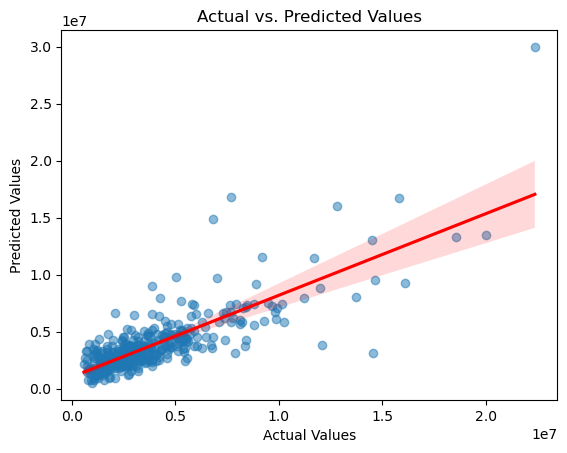

In [95]:
linear_model.fit(X_train_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', bool(False), 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [96]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.427076e+06,1.819935e+06,1.012823e+06,1.163950e+06,0.701817,0.635677,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None


### B. Linear Regression with PCA

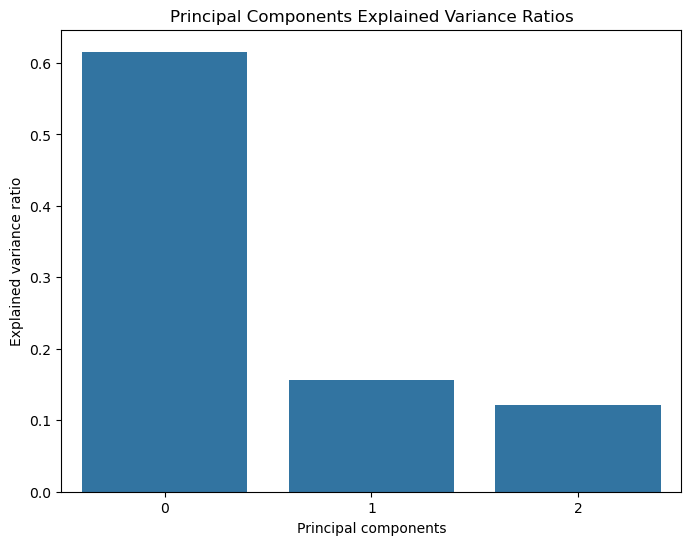

                             PC 1      PC 2      PC 3
public_insurance         0.960466 -0.003223 -0.003723
public_insurance_ratio   0.275962 -0.021438 -0.076193
migrant_patients         0.023620  0.006374  0.974945
public_housing_patients  0.012083  0.006872  0.008426
lep_patients             0.010084  0.026872  0.026635
hispanic_any_race        0.008783  0.035601  0.036899
homeless_patients        0.007382  0.013259  0.014845
total_other_revenue      0.007371  0.997612 -0.011548
medicaid                 0.006957  0.022602  0.019304
total_patients           0.006729  0.016829  0.017358
diverse_patients_sum     0.006483  0.004002  0.001975
school_based_patients    0.006089  0.004223  0.014896
low_income               0.005613  0.018900  0.018359
uninsured                0.005584  0.007602  0.016010
total_grant_funding      0.004918  0.016093  0.006007


In [97]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_rr)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rr)
X_test_pca = pca.transform(X_test_rr)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_rr.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [98]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_rr.index)
X_train_pca_rr = pd.concat([X_train_rr, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_rr.index)
X_test_pca_rr = pd.concat([X_test_rr, X_test_pca_df], axis=1)

R2 Score: 0.6414149733090553, Root Mean Squared Error: 1805546.336879679, Mean Absolute Error: 1167328.0447761193


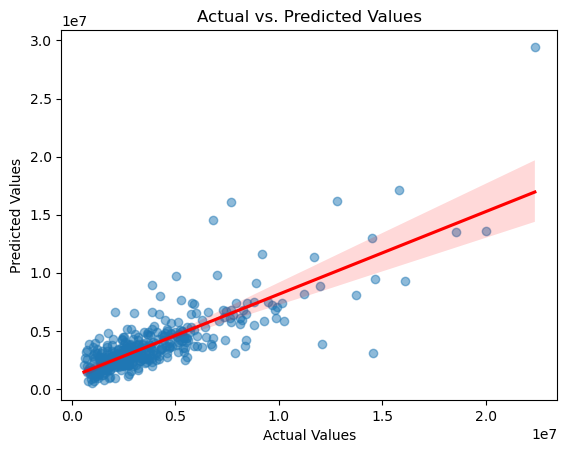

In [99]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [100]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.427076e+06,1.819935e+06,1.012823e+06,1.163950e+06,0.701817,0.635677,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None
1,Linear Regression,reduced_robust,True,1.446953e+06,1.805546e+06,1.020655e+06,1.167328e+06,0.693453,0.641415,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None


### Rounded

R2 Score: 0.6356719061431604, Root Mean Squared Error: 1820661.6154209787, Mean Absolute Error: 1164966.7992064923


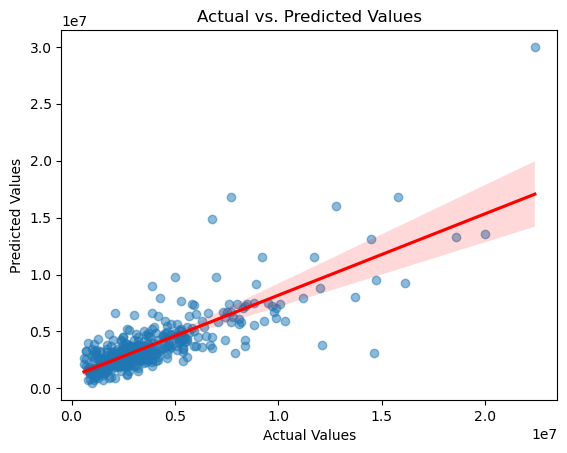

In [101]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_rr, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## II. Reduced & Power Transformed Data

### A. Linear Regression

In [102]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6132553461864595, 0.03144365298639785),
 'neg_mean_squared_error': (-2602495430331.0317, 462229048846.88007),
 'neg_mean_absolute_error': (-1158111.5228426154, 83887.80224131916)}

R2 Score: 0.6119049479995747, Root Mean Squared Error: 1878372.0437015982, Mean Absolute Error: 1298101.7091721224


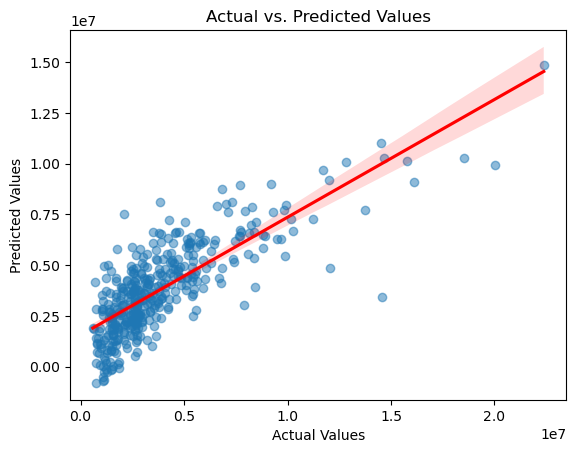

In [103]:
linear_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### B. Linear Regression with PCA

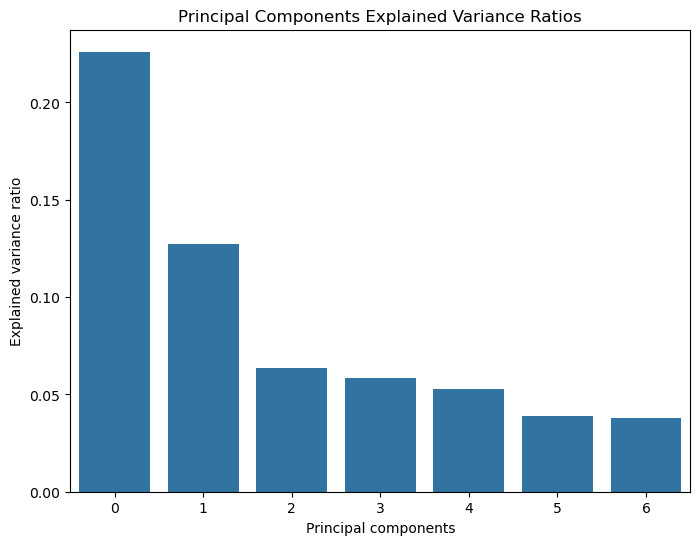

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.263019  0.111760 -0.001459 -0.032677 -0.041693   
low_income                   0.256218 -0.006274  0.042879 -0.009027 -0.132406   
medicaid                     0.255695  0.066153  0.013270 -0.129298 -0.028822   
hispanic_any_race            0.247609 -0.071560 -0.123050  0.109439  0.033228   
lep_patients                 0.239464 -0.101373 -0.125036  0.073149  0.072163   
uninsured                    0.234799 -0.029565 -0.047123  0.118115 -0.038937   
total_grant_funding          0.232464  0.018240  0.022152  0.012449  0.019927   
TotalWeeklyHoursOfOperation  0.213965  0.125728  0.090506  0.002260 -0.158819   
ZipCode_Count                0.205843  0.041551  0.048677 -0.081870 -0.032749   
total_sites                  0.201709  0.121011  0.105531  0.004852 -0.179689   
diverse_patients_sum         0.193075 -0.042475  0.136344 -0.220786 -0.009197   
medicare_18_up              

In [104]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_rp)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rp)
X_test_pca = pca.transform(X_test_rp)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_rp.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [105]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_rp.index)
X_train_pca_rp = pd.concat([X_train_rp, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_rp.index)

X_test_pca_rp = pd.concat([X_test_rp, X_test_pca_df], axis=1)

R2 Score: 0.6137221282330854, Root Mean Squared Error: 1873969.3265188995, Mean Absolute Error: 1292355.489688426


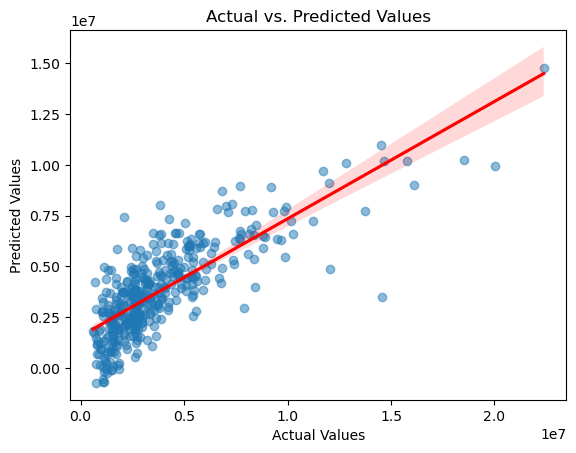

In [106]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rp, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

In [107]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores



{'r2': (0.6130161078497602, 0.03087326669095578),
 'neg_mean_squared_error': (-2603601881132.751, 469681284200.54),
 'neg_mean_absolute_error': (-1159706.0843612037, 85063.70254214092)}

R2 Score: 0.6119397896736288, Root Mean Squared Error: 1879024.5864424997, Mean Absolute Error: 1301315.113220077


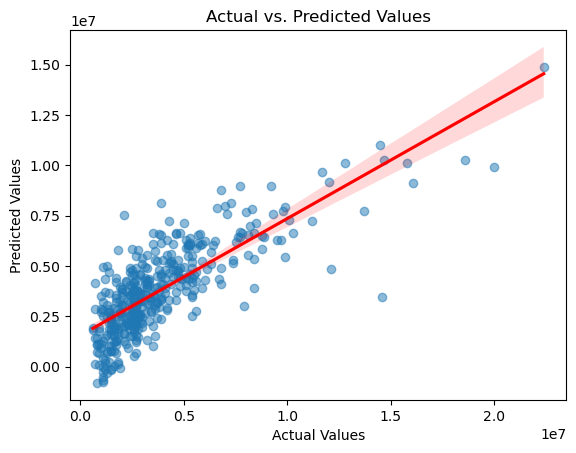

In [108]:
linear_model.fit(X_train_rp, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## III. Imputed & Robust Scaled Data

### A. Linear Regression

In [109]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.1547238125446347, 0.9438295434797247),
 'neg_mean_squared_error': (-5363971213007.419, 5512018199346.475),
 'neg_mean_absolute_error': (-1141935.0421730238, 123364.19004813602)}

R2 Score: 0.6218655804631834, Root Mean Squared Error: 1854110.7347193444, Mean Absolute Error: 1184594.2813578972


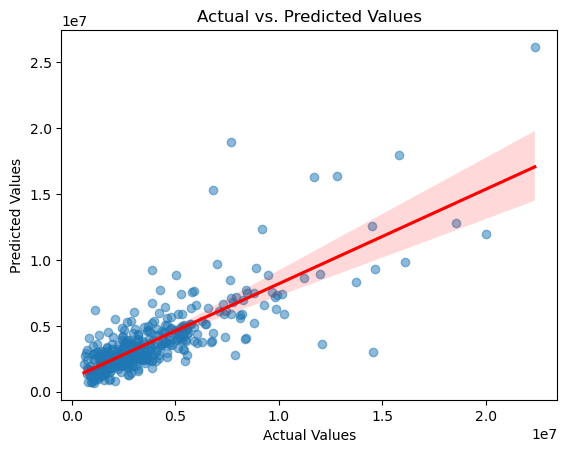

In [110]:
linear_model.fit(X_train_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

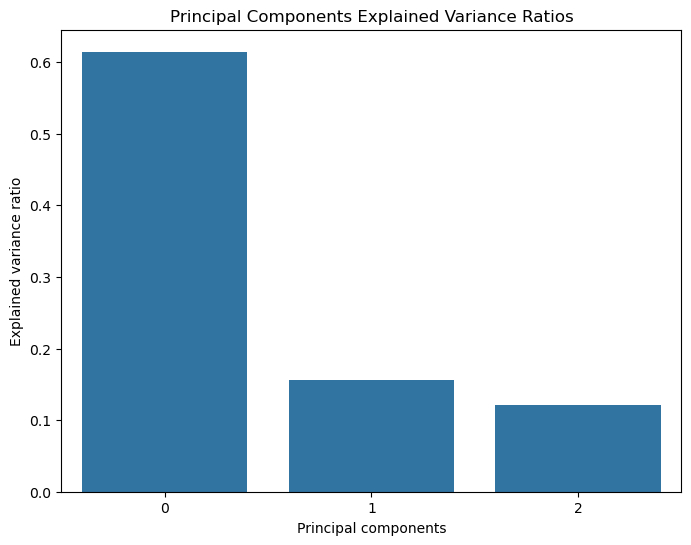

                             PC 1      PC 2      PC 3
public_insurance         0.960372 -0.003685 -0.004033
public_insurance_ratio   0.275892 -0.022165 -0.076837
migrant_patients         0.023710  0.009017  0.974451
public_housing_patients  0.012104  0.007051  0.008611
lep_patients             0.010103  0.027040  0.026665
hispanic_any_race        0.008805  0.035794  0.036894
total_sfs                0.007714  0.022009  0.014189
total_other_revenue      0.007509  0.997057 -0.015162
homeless_patients        0.007399  0.013406  0.014941
total_visits             0.007267  0.009665  0.013702
total_cost_care          0.007115  0.017783  0.012819
medicaid                 0.006973  0.022735  0.019335
total_patients           0.006744  0.016962  0.017411
diverse_patients_sum     0.006492  0.004077  0.002052
school_based_patients    0.006114  0.004458  0.015129


In [111]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_ir)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ir)
X_test_pca = pca.transform(X_test_ir)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_ir.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [112]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_ir.index)
X_train_pca_ir = pd.concat([X_train_ir, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_ir.index)
X_test_pca_ir = pd.concat([X_test_ir, X_test_pca_df], axis=1)


R2 Score: 0.6111156446868939, Root Mean Squared Error: 1880281.1793734455, Mean Absolute Error: 1202281.9701492537


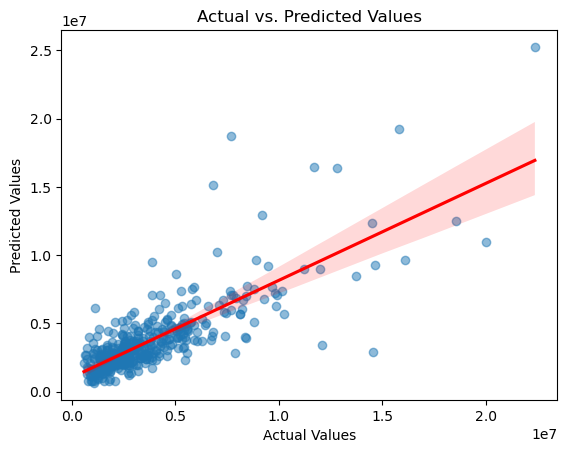

In [113]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ir, X_test_pca_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6216966365604665, Root Mean Squared Error: 1855252.4195806794, Mean Absolute Error: 1185493.052374157


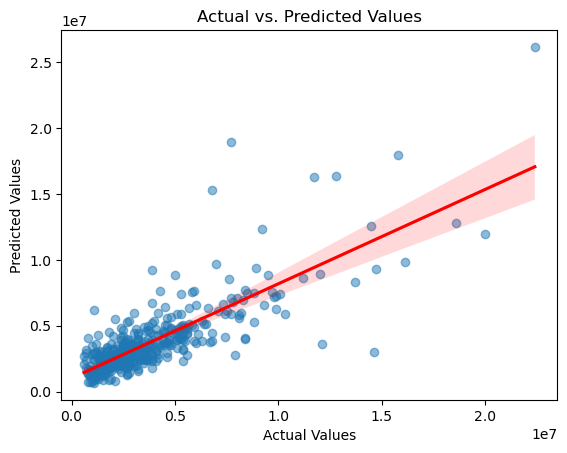

In [114]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ir, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## IV. Imputed & Power Transformed Data

### A. Linear Regression

In [115]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.6051520407794942, 0.03169908668529646),
 'neg_mean_squared_error': (-2649844974990.833, 422243577616.6385),
 'neg_mean_absolute_error': (-1163805.834642091, 79869.42038150752)}

R2 Score: 0.6150466544206603, Root Mean Squared Error: 1870753.697239361, Mean Absolute Error: 1291873.037959073


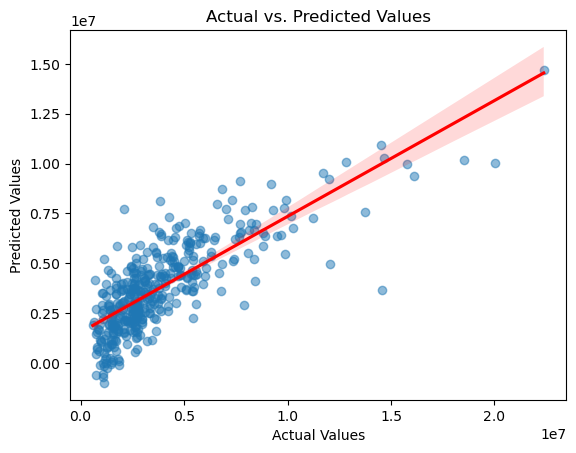

In [116]:
linear_model.fit(X_train_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

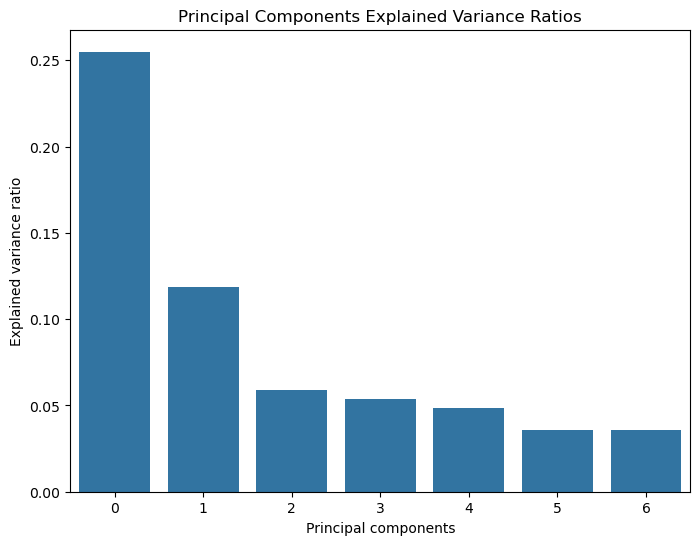

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.241270  0.097821 -0.008909 -0.035389 -0.038984   
total_visits                 0.241204  0.087653  0.019080 -0.029616 -0.028541   
total_cost_care              0.237240  0.078191  0.039379 -0.024889  0.021557   
medicaid                     0.231757  0.054581  0.008942 -0.137464 -0.027288   
low_income                   0.230301 -0.019189  0.033794 -0.013093 -0.125871   
hispanic_any_race            0.220833 -0.084907 -0.128842  0.099896  0.038924   
total_grant_funding          0.213376  0.005975  0.021178  0.011314  0.020722   
uninsured                    0.212025 -0.044642 -0.058760  0.120951 -0.033979   
lep_patients                 0.211805 -0.113701 -0.130712  0.062441  0.076702   
total_sfs                    0.200990 -0.044960 -0.055588  0.077139 -0.011030   
TotalWeeklyHoursOfOperation  0.194491  0.112482  0.082320  0.003246 -0.152671   
ZipCode_Count               

In [117]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_ip)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ip)
X_test_pca = pca.transform(X_test_ip)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_ip.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [118]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_ip.index)
X_train_pca_ip = pd.concat([X_train_ip, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_ip.index)

X_test_pca_ip = pd.concat([X_test_ip, X_test_pca_df], axis=1)



R2 Score: 0.6160297305369413, Root Mean Squared Error: 1868363.4479404627, Mean Absolute Error: 1286503.479530115


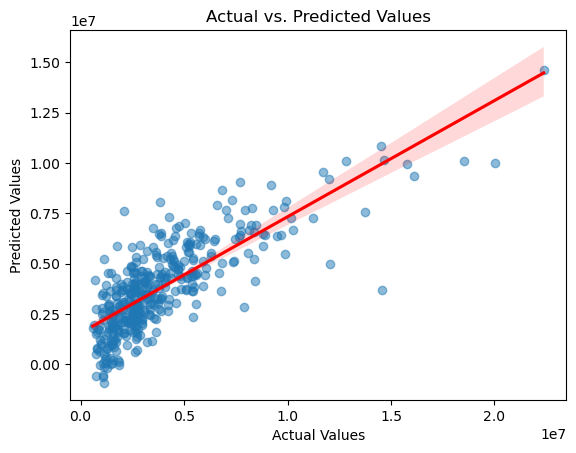

In [119]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ip, X_test_pca_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [120]:
add_model_score('Linear Regression', 'imputed_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6151213936290783, Root Mean Squared Error: 1871305.9179965355, Mean Absolute Error: 1294140.280998289


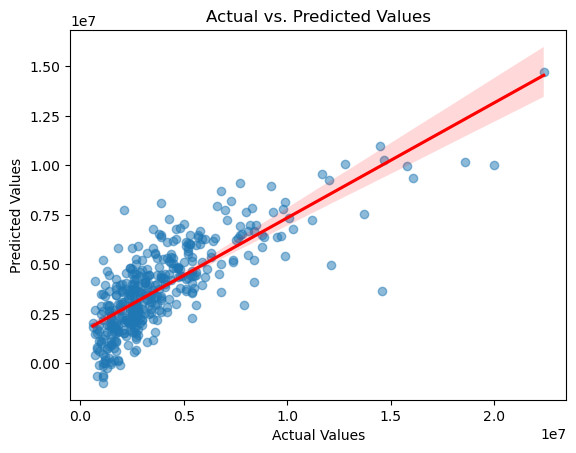

In [121]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ip, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

# Scores Analysis

In [122]:
model_scores.sort_values('cv_mean_r2',ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
3,Linear Regression,reduced_power,False,1.504539e+06,1.878372e+06,1.083078e+06,1.298102e+06,0.668567,0.611905,0.613255,0.031444,-2.602495e+12,4.622290e+11,-1.158112e+06,83887.802241,None
4,Linear Regression,reduced_power,True,1.505725e+06,1.873969e+06,1.082492e+06,1.292355e+06,0.668044,0.613722,0.613255,0.031444,-2.602495e+12,4.622290e+11,-1.158112e+06,83887.802241,None
5,Linear Regression,reduced_power_rounded,False,1.504686e+06,1.879025e+06,1.084128e+06,1.301315e+06,0.668391,0.611940,0.613016,0.030873,-2.603602e+12,4.696813e+11,-1.159706e+06,85063.702542,None
9,Linear Regression,imputed_power,False,1.497745e+06,1.870754e+06,1.074859e+06,1.291873e+06,0.671554,0.615047,0.605152,0.031699,-2.649845e+12,4.222436e+11,-1.163806e+06,79869.420382,None
10,Linear Regression,imputed_power,True,1.498598e+06,1.868363e+06,1.072919e+06,1.286503e+06,0.671180,0.616030,0.605152,0.031699,-2.649845e+12,4.222436e+11,-1.163806e+06,79869.420382,None
11,Linear Regression,imputed_power_rounded,False,1.497925e+06,1.871306e+06,1.075700e+06,1.294140e+06,0.671364,0.615121,0.604820,0.031088,-2.651472e+12,4.299040e+11,-1.165545e+06,80884.979118,None
8,Linear Regression,imputed_robust_rounded,False,1.409706e+06,1.855252e+06,9.969621e+05,1.185493e+06,0.708934,0.621697,0.156067,0.940861,-5.346051e+12,5.475232e+12,-1.141570e+06,123494.045397,None
6,Linear Regression,imputed_robust,False,1.410161e+06,1.854111e+06,9.975919e+05,1.184594e+06,0.708844,0.621866,0.154724,0.943830,-5.363971e+12,5.512018e+12,-1.141935e+06,123364.190048,None
7,Linear Regression,imputed_robust,True,1.438747e+06,1.880281e+06,1.008704e+06,1.202282e+06,0.696920,0.611116,0.154724,0.943830,-5.363971e+12,5.512018e+12,-1.141935e+06,123364.190048,None
2,Linear Regression,reduced_robust_rounded,False,1.426599e+06,1.820662e+06,1.012350e+06,1.164967e+06,0.701916,0.635672,-0.100180,1.436621,-6.881649e+12,8.413993e+12,-1.163096e+06,131512.463568,None


# Ensemble Models

## I. Reduced & Robust Scaled Data

##### Importing Data

### C. Random Forest Regression

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rr, y_train)

y_pred = rf_gridsearch.predict(X_test_rr)
print(rf_gridsearch.score(X_test_rr, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6492099245920367
Best parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 10, 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.6404675974228426, Root Mean Squared Error: 1807929.8758242156, Mean Absolute Error: 1163484.3847525115


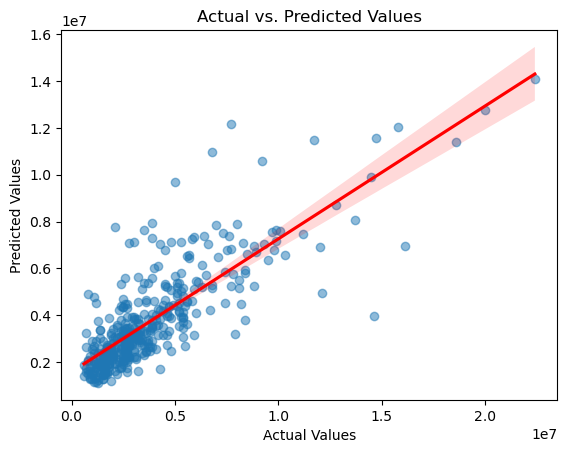

                             feature_importance
uninsured                              0.140647
total_patients                         0.109887
TotalWeeklyHoursOfOperation            0.101227
total_sites                            0.081948
hispanic_any_race                      0.069131
medicaid                               0.052461
low_income                             0.042373
total_grant_funding                    0.029717
lep_patients                           0.029114
private_insurance                      0.024364
medicare_18_up                         0.023686
diverse_patients_sum                   0.021937
ZipCode_Count                          0.020024
uninsured_ratio                        0.015471
homeless_patients                      0.014406


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [38]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6545953219876749, Root Mean Squared Error: 1772052.8515838122, Mean Absolute Error: 1145639.779784809


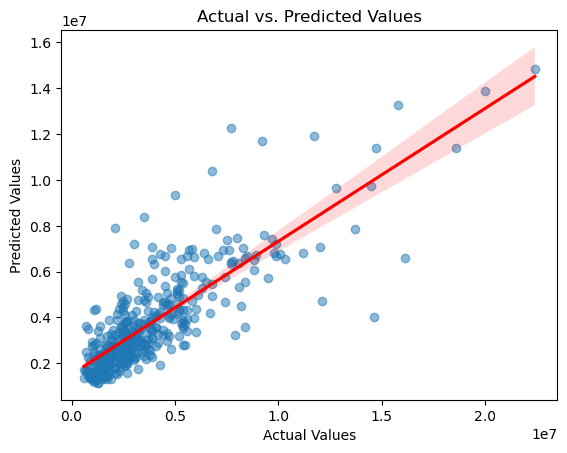

                             feature_importance
total_patients                         0.129333
uninsured                              0.123796
TotalWeeklyHoursOfOperation            0.094439
hispanic_any_race                      0.078074
low_income                             0.058248
total_grant_funding                    0.050412
total_sites                            0.047250
medicaid                               0.038432
diverse_patients_sum                   0.032192
lep_patients                           0.027866
medicare_18_up                         0.020203
ZipCode_Count                          0.020065
PC 1                                   0.016777
homeless_patients                      0.014747
private_insurance                      0.013504


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [39]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.656887004219823, Root Mean Squared Error: 1766857.3572303308, Mean Absolute Error: 1129812.76783168


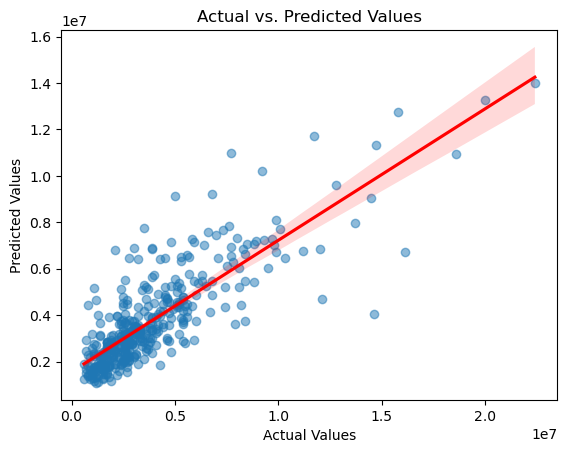

                             feature_importance
uninsured                              0.164008
total_patients                         0.088140
TotalWeeklyHoursOfOperation            0.081886
total_grant_funding                    0.072696
total_sites                            0.058888
diverse_patients_sum                   0.050908
hispanic_any_race                      0.048226
medicaid                               0.042082
low_income                             0.041565
medicare_18_up                         0.029569
lep_patients                           0.026744
SiteCity_Count                         0.018306
private_insurance                      0.016711
homeless_patients                      0.015545
migrant_patients                       0.015504


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [40]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## II. Reduced & Power Transformed Data

##### Importing Data

### C. Random Forest Regressor with GridSearch

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rp, y_train)

y_pred = rf_gridsearch.predict(X_test_rp)
print(rf_gridsearch.score(X_test_rp, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6442705169128433
Best parameters: {'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 20, 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.652052633023015, Root Mean Squared Error: 1778563.3559286303, Mean Absolute Error: 1146792.754278607


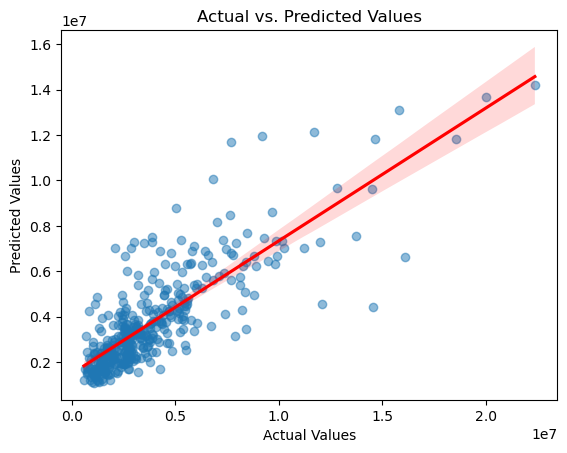

                             feature_importance
uninsured                              0.218993
total_patients                         0.150007
TotalWeeklyHoursOfOperation            0.101252
hispanic_any_race                      0.065222
total_sites                            0.053338
total_grant_funding                    0.039091
medicaid                               0.033844
low_income                             0.026129
diverse_patients_sum                   0.019568
migrant_patients                       0.016783
SiteCity_Count                         0.015379
medicare_18_up                         0.015222
private_insurance                      0.013581
homeless_patients                      0.012120
ZipCode_Count                          0.011456


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [42]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6645252071218952, Root Mean Squared Error: 1746395.1223844693, Mean Absolute Error: 1137453.835323383


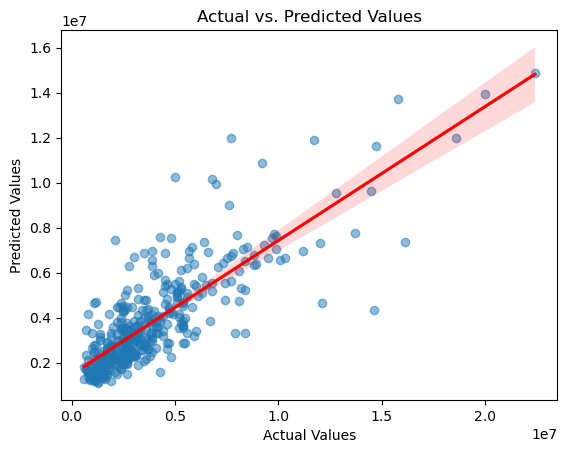

                             feature_importance
PC 1                                   0.206883
uninsured                              0.125655
TotalWeeklyHoursOfOperation            0.107581
total_patients                         0.092238
total_grant_funding                    0.036844
low_income                             0.034293
hispanic_any_race                      0.034163
lep_patients                           0.021928
medicaid                               0.020870
total_sites                            0.017898
medicare_18_up                         0.015181
homeless_patients                      0.013512
diverse_patients_sum                   0.012389
PC 4                                   0.012318
SiteCity_Count                         0.011395


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [43]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6410460829899338, Root Mean Squared Error: 1807183.5044913045, Mean Absolute Error: 1176666.6666666667


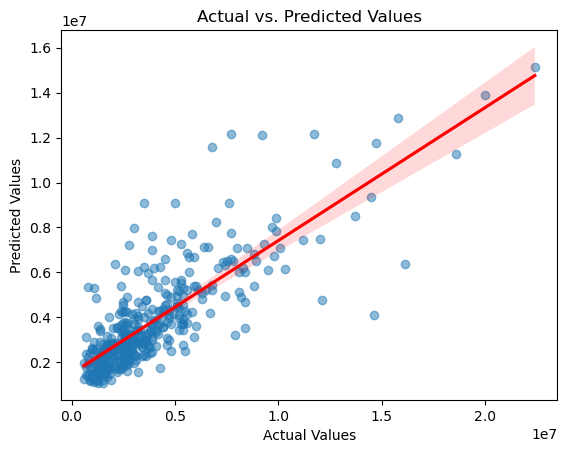

                             feature_importance
uninsured                              0.243167
total_patients                         0.153708
TotalWeeklyHoursOfOperation            0.114377
hispanic_any_race                      0.048786
low_income                             0.040265
total_sites                            0.038724
total_grant_funding                    0.034474
diverse_patients_sum                   0.020555
medicaid                               0.019960
lep_patients                           0.018870
medicare_18_up                         0.016593
migrant_patients                       0.012760
homeless_patients                      0.012508
ZipCode_Count                          0.011604
state_freq_enc                         0.011194


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [44]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power_rounded', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## III. Imputed & Robust Scaled Data

##### Importing Data

### B. Random Forest Regressor

In [45]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_ir, y_train)

y_pred = rf_gridsearch.predict(X_test_ir)
print(rf_gridsearch.score(X_test_ir, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6350143072750846
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 20, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6489676526799016, Root Mean Squared Error: 1786430.5296062564, Mean Absolute Error: 1174163.9819903646


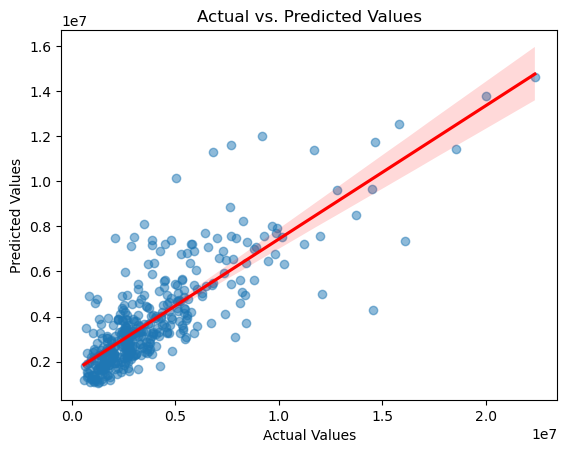

                             feature_importance
uninsured                              0.186076
total_patients                         0.108679
TotalWeeklyHoursOfOperation            0.091812
total_visits                           0.076042
total_sfs                              0.074720
total_cost_care                        0.064150
hispanic_any_race                      0.044138
total_grant_funding                    0.029825
total_sites                            0.025473
low_income                             0.018145
medicaid                               0.016563
diverse_patients_sum                   0.014758
SiteCity_Count                         0.012417
migrant_patients                       0.010892
homeless_patients                      0.010560


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [46]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6484470091931205, Root Mean Squared Error: 1788456.180700021, Mean Absolute Error: 1181970.9367193377


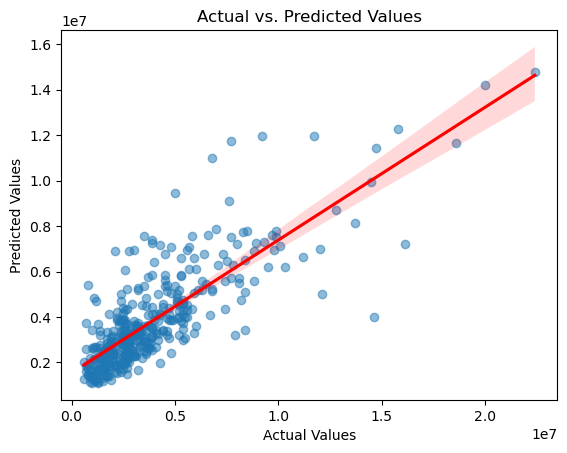

                             feature_importance
uninsured                              0.174521
total_patients                         0.138007
TotalWeeklyHoursOfOperation            0.092067
total_sfs                              0.087575
total_cost_care                        0.052730
hispanic_any_race                      0.048371
total_visits                           0.038477
medicaid                               0.027352
total_sites                            0.023966
total_grant_funding                    0.022744
low_income                             0.019649
SiteCity_Count                         0.014337
diverse_patients_sum                   0.012211
homeless_patients                      0.012193
lep_patients                           0.011910


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [47]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## IV. Imputed & Power Transformed Data

##### Importing Data

### B. Random Forest Regressor

In [48]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, scoring='r2', cv=kf)

rf_gridsearch.fit(X_train_ip, y_train)

y_pred = rf_gridsearch.predict(X_test_ip)
print(rf_gridsearch.score(X_test_ip, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6497870790522932
Best parameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.4900466185897351, Root Mean Squared Error: 2153167.425704682, Mean Absolute Error: 1311964.340783729


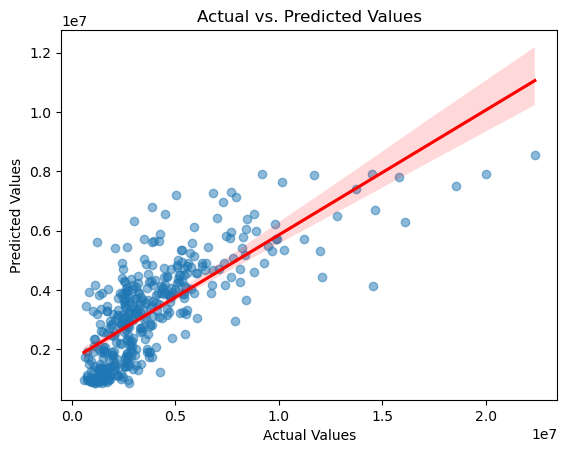

                             feature_importance
uninsured                              0.334344
total_patients                         0.106565
TotalWeeklyHoursOfOperation            0.087580
total_cost_care                        0.073628
hispanic_any_race                      0.059567
total_sfs                              0.034557
total_sites                            0.019064
total_visits                           0.015078
diverse_patients_sum                   0.013198
low_income                             0.012644
total_other_revenue                    0.012295
SiteCity_Count                         0.011441
medicaid                               0.011013
total_grant_funding                    0.010163
homeless_patients                      0.009149


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [49]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.4668806654548062, Root Mean Squared Error: 2202394.54155881, Mean Absolute Error: 1333559.632554184


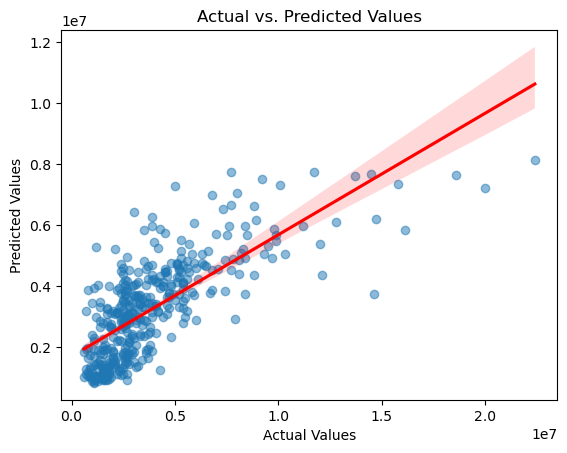

                             feature_importance
uninsured                              0.329547
total_patients                         0.113706
total_cost_care                        0.081894
TotalWeeklyHoursOfOperation            0.068803
hispanic_any_race                      0.055098
total_sfs                              0.036220
total_visits                           0.023493
total_sites                            0.017951
total_grant_funding                    0.013902
diverse_patients_sum                   0.013675
total_other_revenue                    0.011843
medicaid                               0.011774
SiteCity_Count                         0.010477
migrant_patients                       0.009804
low_income                             0.008872


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_3939/3590056762.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [50]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

# Scoring Summary

In [51]:
model_scores.sort_values('score_r2_test', ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
16,Random Forest Regressor,reduced_power,True,5.866193e+05,1.746395e+06,3.935727e+05,1.137454e+06,0.949615,0.664525,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
14,Random Forest Regressor,reduced_robust_rounded,False,7.197423e+05,1.766857e+06,5.282990e+05,1.129813e+06,0.924127,0.656887,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
13,Random Forest Regressor,reduced_robust,True,7.258431e+05,1.772053e+06,5.320776e+05,1.145640e+06,0.922861,0.654595,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
15,Random Forest Regressor,reduced_power,False,6.036001e+05,1.778563e+06,4.013798e+05,1.146793e+06,0.946656,0.652053,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
18,Random Forest Regressor,imputed_robust,False,6.958152e+05,1.786431e+06,5.150680e+05,1.174164e+06,0.929111,0.648968,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
19,Random Forest Regressor,imputed_robust_rounded,False,6.893884e+05,1.788456e+06,5.081914e+05,1.181971e+06,0.930391,0.648447,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
17,Random Forest Regressor,reduced_power_rounded,True,6.284537e+05,1.807184e+06,4.153049e+05,1.176667e+06,0.942153,0.641046,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
12,Random Forest Regressor,reduced_robust,False,7.219610e+05,1.807930e+06,5.372027e+05,1.163484e+06,0.923684,0.640468,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,reduced_robust_rounded,False,1.427679e+06,1.821046e+06,1.014567e+06,1.164526e+06,0.701465,0.635518,-0.098124,1.432765,-6.869986e+12,8.391041e+12,-1.164869e+06,134165.105598,None
1,Linear Regression,reduced_robust,True,1.446048e+06,1.820398e+06,1.023676e+06,1.167988e+06,0.693836,0.635491,-0.099066,1.434594,-6.890004e+12,8.430002e+12,-1.165344e+06,134367.941047,None


In [52]:
best_forest = model_scores[model_scores['model_type'] == 'Random Forest Regressor']\
                .sort_values('score_r2_test', ascending=False).head(2)
best_linreg = model_scores[model_scores['model_type'] == 'Linear Regression']\
                .sort_values('score_r2_test', ascending=False).head(2)

top_models = pd.concat([best_forest, best_linreg], ignore_index=True)
top_models

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Random Forest Regressor,reduced_power,True,5.866193e+05,1.746395e+06,3.935727e+05,1.137454e+06,0.949615,0.664525,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Random Forest Regressor,reduced_robust_rounded,False,7.197423e+05,1.766857e+06,5.282990e+05,1.129813e+06,0.924127,0.656887,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,reduced_robust_rounded,False,1.427679e+06,1.821046e+06,1.014567e+06,1.164526e+06,0.701465,0.635518,-0.098124,1.432765,-6.869986e+12,8.391041e+12,-1.164869e+06,134165.105598,None
3,Linear Regression,reduced_robust,True,1.446048e+06,1.820398e+06,1.023676e+06,1.167988e+06,0.693836,0.635491,-0.099066,1.434594,-6.890004e+12,8.430002e+12,-1.165344e+06,134367.941047,None


In [65]:
print(list(top_models[top_models['model_type'] == 'Random Forest Regressor']['best_params'].head(2)))

[{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 20, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}, {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}]


# Model Tuning

**Reduced Power Model with PCA Features**

[{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': None, 'max_features': 20, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}]


In [63]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [30, 50, 90], 
    'max_depth': [None, 50, 100],
    'max_features': ['sqrt', 20, 35, 50, 'log2'], 
    'min_samples_split': [2, 3, 5], 
    'min_samples_leaf': [1, 2, 4],  
    'criterion': ['friedman_mse', 'squared_error'], 
    'bootstrap': [True],  
    'n_jobs': [-1], 
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_pca_rp, y_train)

y_pred = forest_gs.predict(X_test_pca_rp)
print(forest_gs.score(X_test_pca_rp, y_test))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.6593583014499949
Best parameters: {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 100, 'max_features': 50, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 90, 'n_jobs': -1}


R2 Score: 0.6661138856988604, Root Mean Squared Error: 1742255.0900037768, Mean Absolute Error: 1134002.5798137847


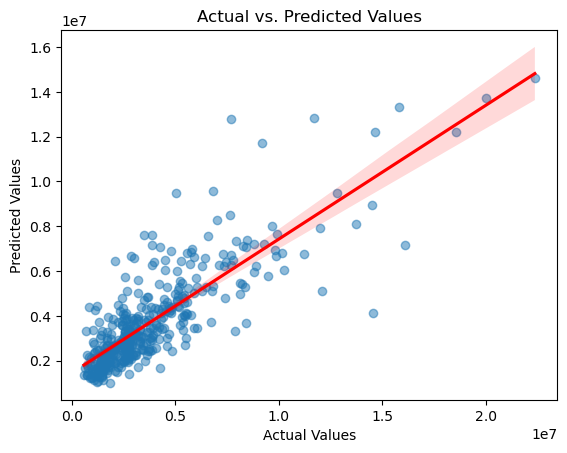

                             feature_importance
PC 1                                   0.251120
uninsured                              0.197908
total_patients                         0.119851
TotalWeeklyHoursOfOperation            0.066246
hispanic_any_race                      0.031517
low_income                             0.025216
PC 4                                   0.016192
total_sites                            0.015957
medicaid                               0.013044
SiteCity_Count                         0.012076
diverse_patients_sum                   0.010612
PC 7                                   0.010271
total_grant_funding                    0.010084
uninsured_ratio                        0.009769
PC 3                                   0.009412


In [79]:
rf_model_1 = RandomForestRegressor(**best_params, random_state=65)

rf_model_1.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model_1, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model_1.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

In [176]:
y_pred_train = rf_model_1.predict(X_train_pca_rp)

In [190]:
residuals = y_test - y_pred

# Create a DataFrame to analyze the residuals
results_df = pd.DataFrame({
    'Actual': y_test.flatten(), 
    'Predicted': y_pred.flatten(),
    'Residuals': residuals.flatten(),
    'Absolute_Residuals': abs(residuals).flatten()
})

# Sort the df by absolute residuals in descending order
results_df = results_df.sort_values(by='Absolute_Residuals', ascending=False)

results_df[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,402.00
mean,1287115.59
std,1355079.99
min,222.93
25%,424598.87
50%,976725.73
75%,1676779.43
max,10983782.22


In [178]:
residuals_train = y_train - y_pred_train

# Create a DataFrame to analyze the residuals
results_df_train = pd.DataFrame({
    'Actual': y_train.flatten(), 
    'Predicted': y_pred_train.flatten(),
    'Residuals': residuals_train.flatten(),
    'Absolute_Residuals': abs(residuals_train).flatten()
})

# Sort the df by absolute residuals in descending order
results_df_train = results_df_train.sort_values(by='Absolute_Residuals', ascending=False)

In [179]:
combined_data_test = pd.merge(X_test_rr, results_df, left_index=True, right_index=True, how='inner')

combined_data_train = pd.merge(X_train_rr, results_df_train, left_index=True, right_index=True, how='inner')
combined_data = pd.concat([combined_data_train, combined_data_test], axis=0)

In [180]:
df = pd.read_csv(DATA_PATH +'data_new_features.csv')
df.shape

(1340, 74)

In [181]:
combined_data = pd.merge(combined_data, df[['HealthCenterName', 'HealthCenterState']], left_index=True, right_index=True, how='inner')


In [191]:
combined_data.head()

,FundingCHC,FundingMHC,FundingHO,FundingPH,total_other_revenue,hispanic_any_race,total_patients,lep_patients,medicare_18_up,migrant_patients,...,other_revenue_category_1M to 30M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero,Actual,Predicted,Residuals,Absolute_Residuals,HealthCenterName,HealthCenterState
0,0.0,0.0,1.0,0.0,0.100244,0.561632,-0.286709,0.358945,-0.468868,-0.086022,...,0.0,0.0,0.0,0.0,1472994,1.961754e+06,-4.887604e+05,4.887604e+05,"HOLYOKE HEALTH CENTER, INC.",MA
0,0.0,0.0,0.0,0.0,0.172906,0.070840,0.126890,0.833120,-0.075277,-0.208909,...,0.0,0.0,0.0,0.0,2547838,3.765379e+06,-1.217541e+06,1.217541e+06,"HOLYOKE HEALTH CENTER, INC.",MA
1,0.0,0.0,1.0,1.0,-0.067640,-0.163880,-0.217793,-0.182834,0.051618,0.540707,...,0.0,0.0,0.0,0.0,5585282,4.721877e+06,8.634055e+05,8.634055e+05,MAINE MOBILE HEALTH PROGRAM INC.,ME
1,0.0,0.0,0.0,0.0,-0.268738,-0.050620,1.380709,-0.242674,1.579095,-0.208909,...,0.0,0.0,0.0,1.0,2425436,4.821219e+06,-2.395783e+06,2.395783e+06,MAINE MOBILE HEALTH PROGRAM INC.,ME
2,0.0,0.0,0.0,0.0,0.503929,-0.217187,-0.190533,-0.144014,-0.299387,-0.129032,...,0.0,0.0,0.0,0.0,1370964,2.136306e+06,-7.653423e+05,7.653423e+05,"FAIR HAVEN COMMUNITY HEALTH CLINIC, INC.",CT


In [189]:
combined_data[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,1340.00
mean,752075.71
std,941933.55
min,222.93
25%,205993.03
50%,481942.51
75%,972291.41
max,10983782.22


## Reduced Robust Rounded

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

In [66]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [35, 50, 75],
    'max_depth': [5, 10, 30],    
    'max_features': ['sqrt', 0.5, 'log2'],  
    'min_samples_split': [2, 4, 6],  
    'min_samples_leaf': [1, 2],   
    'criterion': ['friedman_mse', 'squared_error'], 
    'bootstrap': [True],            
    'n_jobs': [-1],                  
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_rr, y_train_rounded)

y_pred = forest_gs.predict(X_test_rr)
print(forest_gs.score(X_test_rr, y_test_rounded))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.6458550923358068
Best parameters: {'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.6455582168429901, Root Mean Squared Error: 1795789.2265206596, Mean Absolute Error: 1152872.1991059163


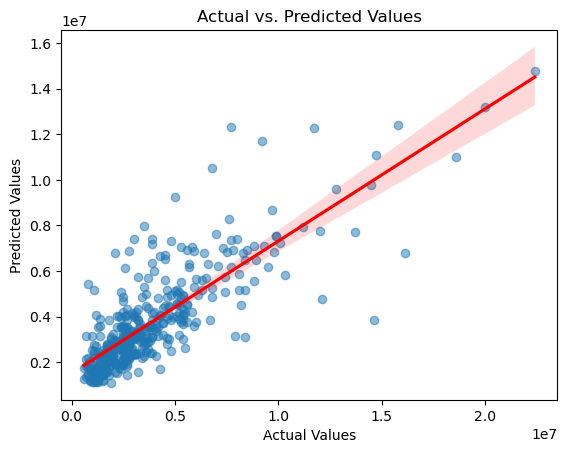

                             feature_importance
uninsured                              0.246796
total_patients                         0.192335
TotalWeeklyHoursOfOperation            0.092965
hispanic_any_race                      0.060667
total_grant_funding                    0.054742
low_income                             0.040388
total_sites                            0.026582
diverse_patients_sum                   0.015733
medicare_18_up                         0.014569
medicaid                               0.013707
SiteCity_Count                         0.011754
homeless_patients                      0.011530
uninsured_ratio                        0.010933
migrant_patients                       0.010125
migrant_patients_ratio                 0.009995


In [78]:
rf_model_2 = RandomForestRegressor(**best_params, random_state=65)

rf_model_2.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model_2, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model_2.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

# Removing extreme outliers

In [68]:
X_train_rr_subset = pd.read_csv(DATA_PATH +'modeling/X_train_subset.csv')
X_test_rr_subset = pd.read_csv(DATA_PATH + 'modeling/X_test_subset.csv')
y_train_subset = pd.read_csv(DATA_PATH  +'modeling/y_train_subset.csv').values.ravel()
y_test_subset = pd.read_csv(DATA_PATH + 'modeling/y_test_subset.csv').values.ravel()

R2 Score: 0.5242513550088213, Root Mean Squared Error: 1082642.4908361556, Mean Absolute Error: 849302.2398706313


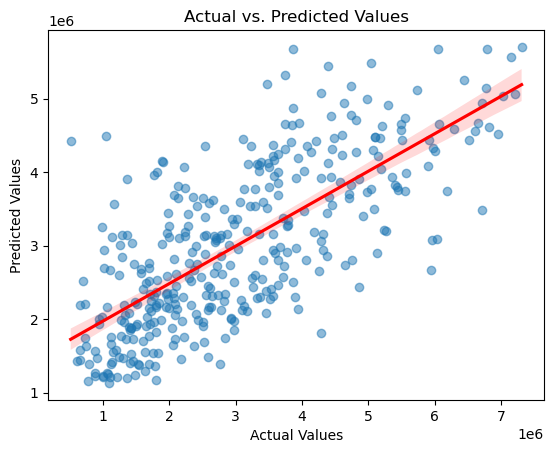

                             feature_importance
total_18_up                            0.288620
total_patients                         0.114442
TotalWeeklyHoursOfOperation            0.059916
low_income                             0.045280
uninsured                              0.033952
hispanic_any_race                      0.022802
total_0_17                             0.020215
diverse_patients_sum                   0.019190
total_grant_funding                    0.018997
SiteCity_Count                         0.018855
homeless_patients                      0.018386
migrant_patients                       0.016874
fpl_over_200                           0.016777
diverse_race_proportion                0.016546
medicaid_ratio                         0.015536


In [69]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr_subset, y_train_subset)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr_subset, X_test_rr_subset, y_train_subset, y_test_subset)

sns.regplot(x=y_test_subset.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr_subset.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

# Results

The model called rf_model_1 performed the best in terms of R2 score. This model was trained and tested with the Reduced Power train/test split that also included PCA features in the dataset. 

Here were the results:
R2 Score: 0.6661138856988604, Root Mean Squared Error: 1742255.0900037773, Mean Absolute Error: 1134002.5798137847


The linear regression models and random forest regressors performed better using the reduced dataset, which columns containing a lot of values were removed instead of imputed.